In [12]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.LIS_LSM as LL
import HydroAI.Plot as Plot
import HydroAI.Data as Data
importlib.reload(LL);
importlib.reload(Plot);
importlib.reload(Data);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
# get the nc files
LIS_LSM_FP = cpuserver_data_FP + '/LISF/OUTPUT/noahmp401_001_Jeddah/SURFACEMODEL'
nc_file_paths = LL.get_nc_file_paths(LIS_LSM_FP)

# check the variable names and their units
Data.get_nc_variable_names_units(nc_file_paths[0]);

+------------------+----------------------------+-----------------------------------+
| Name             | Long Name                  | Units                             |
+==================+============================+===================================+
| lat              | latitude                   | degree_north                      |
+------------------+----------------------------+-----------------------------------+
| lon              | longitude                  | degree_east                       |
+------------------+----------------------------+-----------------------------------+
| time             | time                       | minutes since 2011-01-01 01:00:00 |
+------------------+----------------------------+-----------------------------------+
| Qs_tavg          | surface runoff             | kg m-2 s-1                        |
+------------------+----------------------------+-----------------------------------+
| SoilMoist_tavg   | soil moisture content      | m^3 

In [10]:
lat = LL.get_variable_from_nc(nc_file_paths[0], 'lat', layer_index=0)
lon = LL.get_variable_from_nc(nc_file_paths[0], 'lon', layer_index=0)

2
(100, 56)
2
(100, 56)


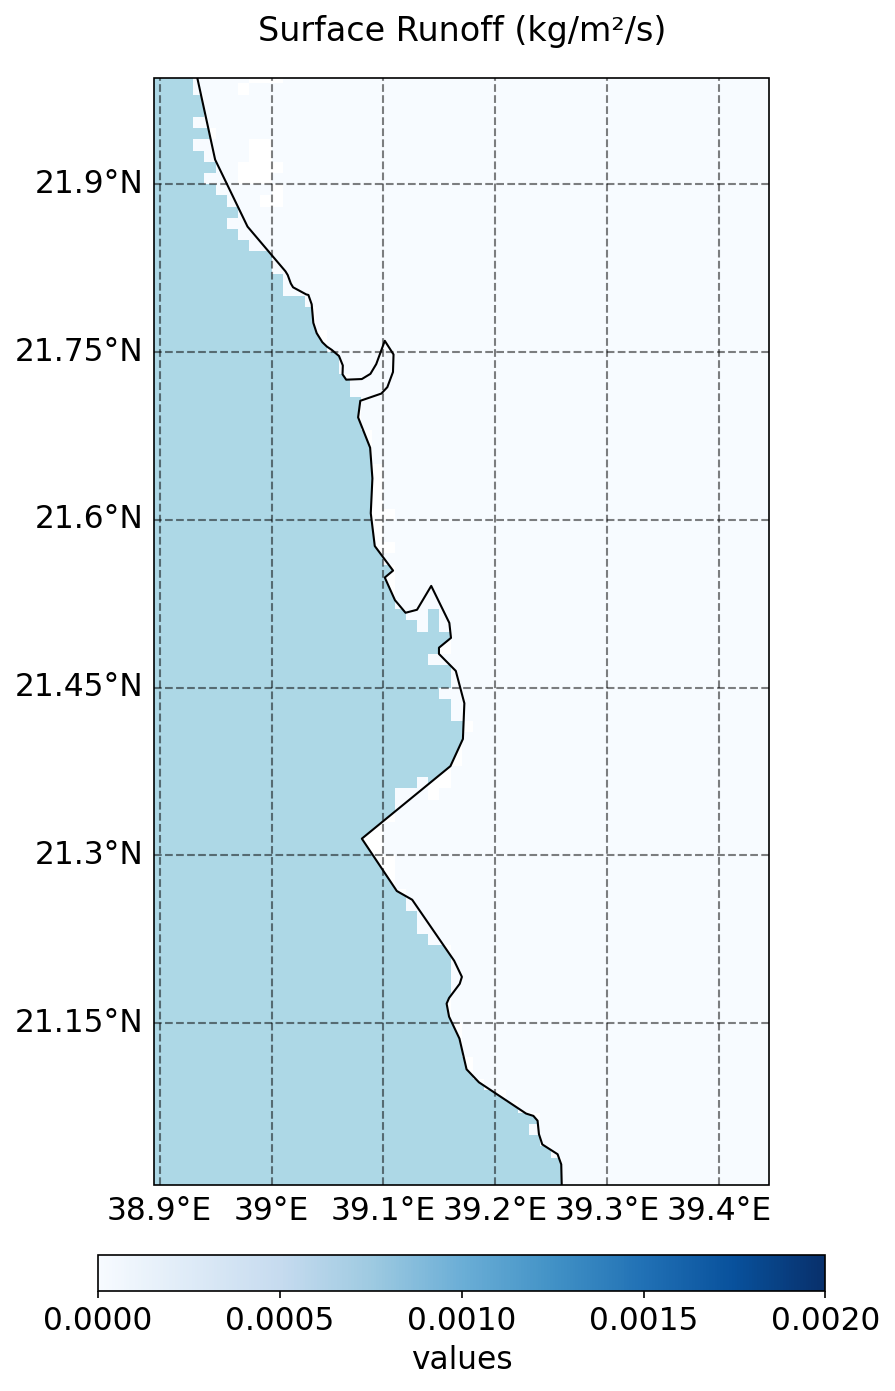

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [13]:
closest_index_1 = LL.find_date_index(nc_file_paths, '20221127100000')
closest_index_2 = LL.find_date_index(nc_file_paths, '20221127100000')
p  = LL.get_variable_from_nc(nc_file_paths[closest_index_1], 'TotalPrecip_tavg', layer_index=0)
sm = LL.get_variable_from_nc(nc_file_paths[closest_index_1], 'SoilMoist_tavg', layer_index=0)
q  = LL.get_variable_from_nc(nc_file_paths[closest_index_1], 'Qs_tavg', layer_index=0)
var = q
#Plot.plot_regional_map(lon, lat, var, 'Surface Runoff (kg/m²/s)', 0, 0.00003, 0, cmap='Blues', dem_path=None)
bounds = [38.895, 39.445, 21.005, 21.995]
Plot.plot_map(lon, lat, var,  0, 0.002, 'Surface Runoff (kg/m²/s)', cmap='Blues', bounds=bounds, projection='PlateCarree')

In [14]:
P = np.empty((0,0,0))
Q = np.empty((0,0,0))
for i in range(closest_index_1, closest_index_2):
    data_slice = LL.get_variable_from_nc(nc_file_paths[i], 'TotalPrecip_tavg', layer_index=0)
    if i == closest_index_1:
        P = data_slice[:,:,np.newaxis]
    P = np.dstack((P, data_slice))
    data_slice = LL.get_variable_from_nc(nc_file_paths[i], 'Qs_tavg', layer_index=0)
    if i == closest_index_1:
        Q = data_slice[:,:,np.newaxis]
    Q = np.dstack((Q, data_slice))

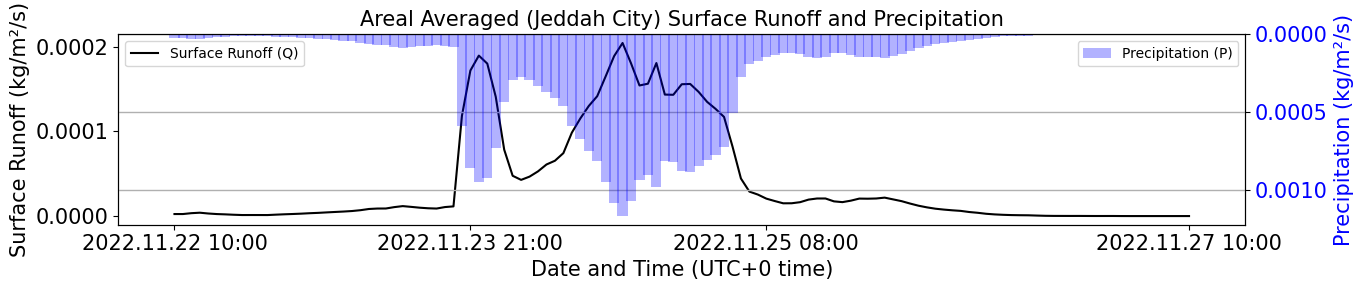

In [15]:
P_TS = Data.average_over_space(P)
Q_TS = Data.average_over_space(Q)

# Generate sample data
start_date = datetime(2022, 11, 22, 10)  # start time
end_date = datetime(2022, 11, 27, 11)    # end time
delta = timedelta(hours=1)               # hourly data
dates = np.arange(start_date, end_date, delta).astype(datetime)

# Create a plot
fig, ax1 = plt.subplots(figsize=(14,3))

# Plotting Q_TS on the left y-axis
ax1.plot(dates, Q_TS, 'k-', label='Surface Runoff (Q)', zorder=1)
ax1.set_xlabel('Date and Time (UTC+0 time)')
ax1.set_ylabel('Surface Runoff (kg/m²/s)', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.legend(loc='upper left')

# Create a second y-axis for P_TS
ax2 = ax1.twinx()
ax2.bar(dates, P_TS, width=0.05, label='Precipitation (P)', color='b', align='center', alpha=0.3, zorder=2)
ax2.set_ylabel('Precipitation (kg/m²/s)', color='b')
ax2.invert_yaxis()  # Invert the y-axis for precipitation
ax2.tick_params(axis='y', labelcolor='b')
ax2.legend(loc='upper right')

# Define specific dates for x-axis labels
specific_dates = [datetime(2022, 11, 22, 10), datetime(2022, 11, 23, 21), datetime(2022, 11, 25, 8), datetime(2022, 11, 27, 10)]
specific_labels = [date.strftime('%Y.%m.%d %H:%M') for date in specific_dates]

# Set custom date ticks and labels
ax1.set_xticks(specific_dates)
ax1.set_xticklabels(specific_labels)

# Rotate date labels for better visibility
plt.xticks(rotation=45)
plt.title('Areal Averaged (Jeddah City) Surface Runoff and Precipitation')
plt.grid()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [14]:
#quick gif
Plot.create_gif_from_maps(nc_file_paths, lon, lat, 'Qs_tavg', 'test.gif', closest_index_1, closest_index_2, 0, cmap='Blues', duration=100)

Processing: 100%|█████████████████████████████| 120/120 [00:26<00:00,  4.50it/s]
